# PyOR also called Python On Resonance
## Author: Vineeth Francis Thalakottoor
## Email: vineeth.thalakottoor@ens.psl.eu or vineethfrancis.physics@gmail.com
## Example: NOE (Liovillie space and Lindblad)

In [1]:
# Define the source path
SourcePath = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_V1/PyOR_Combined/Source_Doc'

# Add source path
import sys
sys.path.append(SourcePath)
import time
%matplotlib ipympl

# Import PyOR package
from PyOR_QuantumSystem import QuantumSystem as QunS
from PyOR_Hamiltonian import Hamiltonian
from PyOR_DensityMatrix import DensityMatrix
from PyOR_QuantumObject import QunObj
from PyOR_HardPulse import HardPulse
from PyOR_Basis import Basis
from PyOR_Evolution import Evolutions
from PyOR_Plotting import Plotting
import PyOR_SignalProcessing as Spro
from PyOR_Commutators import Commutators
from PyOR_QuantumLibrary import QuantumLibrary
from PyOR_Relaxation import RelaxationProcess

In [2]:
# Define the spin system
Spin_list = {"A" : "H1", "B" : "H1"}
QS = QunS(Spin_list,PrintDefault=False)

# initialize the system
QS.Initialize()

### Set parameters

In [3]:
# Master Equation
QS.PropagationSpace = "Liouville"
QS.MasterEquation = "Lindblad"

# B0 Field in Tesla, Static Magnetic field (B0) along Z
QS.B0 = 9.4

# Offset Frequency in rotating frame (Hz)
QS.OFFSET["A"] = 10.0
QS.OFFSET["B"] = 50.0

# Define J coupling between Spins 
QS.JcoupleValue("A","B",5.0)

# Define paris of spins coupled by dipolar interaction
QS.Dipole_Pairs = [("A","B")]

# Define initial and final Spin Temperature
QS.I_spintemp["A"] = 300.0
QS.I_spintemp["B"] = 300.0
QS.F_spintemp["A"] = 300.0
QS.F_spintemp["B"] = 300.0

# Relaxation Process
QS.Rprocess = "Auto-correlated Dipolar Homonuclear"
QS.RelaxParDipole_tau = 10.0e-12
QS.RelaxParDipole_bIS = [30.0e3]

QS.Update()

Rotating frame frequencies: {'A': -2514706800.0, 'B': -2514706800.0}
Offset frequencies: {'A': 10.0, 'B': 50.0}
Initial spin temperatures: {'A': 300.0, 'B': 300.0}
Final spin temperatures: {'A': 300.0, 'B': 300.0}
Radiation damping gain: {'A': 0, 'B': 0}
Radiation damping phase: {'A': 0, 'B': 0}

Rprocess = Auto-correlated Dipolar Homonuclear
RelaxParDipole_tau = 1e-11
DipolePairs = [('A', 'B')]
RelaxParDipole_bIS = [30000.0]


### Generate Hamiltonians

In [4]:
# generate Larmor Frequencies
QS.print_Larmor = True
Ham = Hamiltonian(QS)
COMM = Commutators()
Hz = Ham.Zeeman_RotFrame()

# J coupling Hamiltonian
Hj = Ham.Jcoupling()

# Generating the commutation superoperator

QS.RowColOrder = 'C'
QLib = QuantumLibrary(QS)

Hz_L = QLib.CommutationSuperoperator(Hz+Hj)

Larmor Frequency in MHz:  [-400.22802765 -400.22806765]


In [5]:
Hz_L

### product operator basis (Shift Z or PMZ basis)

In [6]:
BS = Basis(QS)

sort = 'negative to positive'
Index = False
Normal = True
Basis_PMZ, coh_PMZ, dic_PMZ = BS.ProductOperators_SpinHalf_PMZ(sort,Index,Normal)

### Initialize Density Matrix

In [7]:
DM = DensityMatrix(QS,Ham)

Thermal_DensMatrix = True

if Thermal_DensMatrix:    
    # High Temperature
    HT_approx = False
    
    # Initial Density Matrix
    rho_in = DM.EquilibriumDensityMatrix(QS.Ispintemp,HT_approx)
    
    # Equlibrium Density Matrix
    rhoeq = DM.EquilibriumDensityMatrix(QS.Fspintemp,HT_approx)
else:
    rho_in = QS.Az + QS.Bz
    rhoeq = QS.Az + QS.Bz   

Trace of density matrix =  1.0
Trace of density matrix =  1.0


In [8]:
# Converting to Liouville
rho_in_L = QLib.DMToVec(rho_in)
rhoeq_L = QLib.DMToVec(rhoeq)

In [9]:
DM.DensityMatrix_Components(Basis_PMZ,dic_PMZ,rho_in_L)

Density Matrix = 2e-05 Iz1 Id2  + 2e-05 Id1 Iz2  + 0.5 Id1 Id2 


### Pulse

In [10]:
HardP = HardPulse(QS)

flip_angle1 = 0.0   # Flip angle Spin 1
flip_angle2 = 180.0 # Flip angle Spin 2

rho = HardP.Rotate_Pulse(rho_in_L,flip_angle1,QS.Ay)
rho = HardP.Rotate_Pulse(rho,flip_angle2,QS.By)

In [11]:
DM.DensityMatrix_Components(Basis_PMZ,dic_PMZ,rho)

Density Matrix = 2e-05 Iz1 Id2  + -2e-05 Id1 Iz2  + 0.5 Id1 Id2 


## Evolution 

In [12]:
QS.AcqDT = 0.0001
QS.AcqAQ = 30.0
QS.OdeMethod = 'DOP853'
QS.PropagationMethod = "Relaxation Lindblad"

# Relaxation Superoperator
RPro = RelaxationProcess(QS)
R_L = RPro.Relaxation()

EVol = Evolutions(QS,Ham)

start_time = time.time()
t, rho_t = EVol.Evolution(rho,rhoeq,Hz_L,R_L)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Larmor Frequency in MHz:  [-400.22802765 -400.22806765]
Larmor Frequency in MHz:  [-400.22802765 -400.22806765]
Total time = 0.7395715713500977 seconds 


### Expectation Value

In [13]:
det_Z1 = QLib.DMToVec(QS.Az)
det_Z2 = QLib.DMToVec(QS.Bz)

t, signal_Z1 = EVol.Expectation(rho_t,det_Z1)
t, signal_Z2 = EVol.Expectation(rho_t,det_Z2)

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


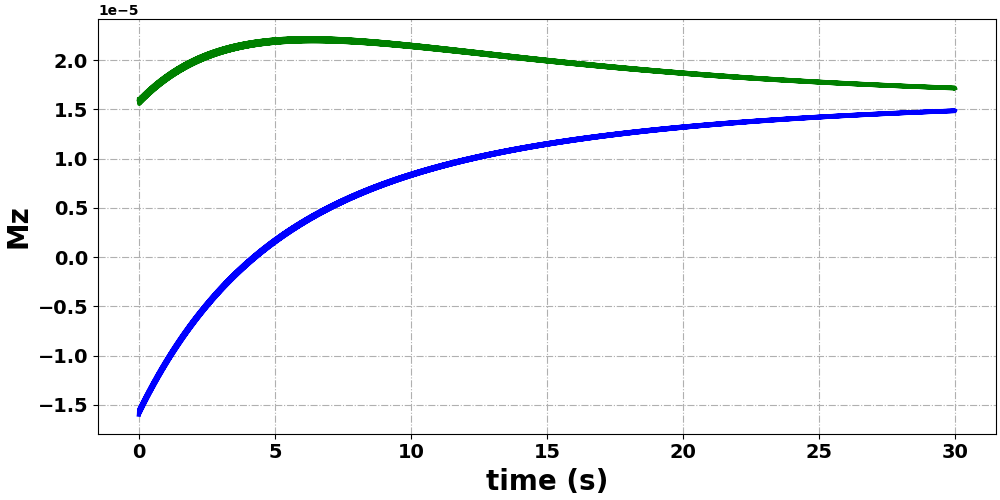

In [14]:
plot = Plotting(QS)
plot.PlotFigureSize = (10,5)
plot.PlotFontSize = 20
plot.PlottingMulti(1,[t,t],[signal_Z1,signal_Z2],"time (s)","Mz",["green","blue"])